In [1]:
%matplotlib inline
import pylab as plt

In [2]:
%%time
from eden.graph import Vectorizer
vectorizer = Vectorizer(r = 3, d = 3)

from eden.util import load_target
y = load_target('http://www.bioinf.uni-freiburg.de/~costa/bursi500.target')

from eden.converter.graph.gspan import gspan_to_eden
graphs = gspan_to_eden('http://www.bioinf.uni-freiburg.de/~costa/bursi500.gspan')

X = vectorizer.transform( graphs )
print 'Instances: %d Features: %d with an avg of %d features per instance' % (X.shape[0], X.shape[1],  X.getnnz()/X.shape[0])

Instances: 499 Features: 1048577 with an avg of 168 features per instance
CPU times: user 4.48 s, sys: 122 ms, total: 4.6 s
Wall time: 5.35 s


In [3]:
%%time
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.kernel_approximation import Nystroem
import numpy as np

#make dense feature representation
n_components=X.shape[0]//4

feature_map_nystroem = Nystroem(gamma=.001, n_components=n_components)
X_explicit=feature_map_nystroem.fit_transform(X)

# use RandomTreesEmbedding to transform data
hasher = RandomTreesEmbedding(n_estimators=256, random_state=0, max_depth=16)
X_transformed = hasher.fit_transform(X_explicit)


# Visualize result using PCA
pca = TruncatedSVD(n_components=2)
X_reduced = pca.fit_transform(X_transformed)

CPU times: user 255 ms, sys: 36.1 ms, total: 292 ms
Wall time: 312 ms


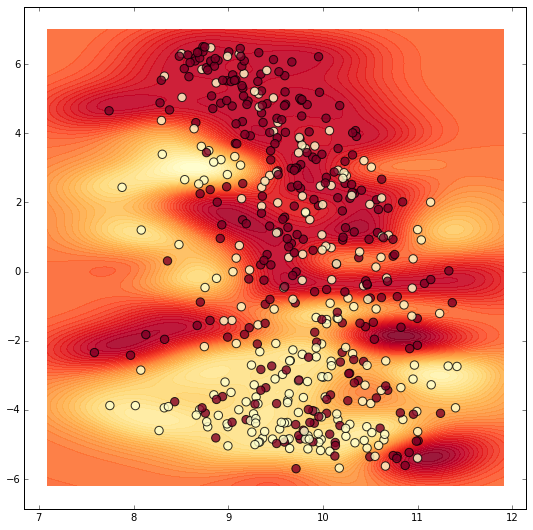

CPU times: user 1.51 s, sys: 12.8 ms, total: 1.52 s
Wall time: 1.53 s


In [4]:
%%time

size=9
plt.figure(figsize=(size,size))

#make mesh
h = .02  # step size in the mesh
b = 0.5 # border size
x_min, x_max = X_reduced[:, 0].min() - b, X_reduced[:, 0].max() + b
y_min, y_max = X_reduced[:, 1].min() - b, X_reduced[:, 1].max() + b
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#train a classifier
clf=SVC(gamma=2)
clf.fit(X_reduced,y)
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
# Put the result into a color plot
levels = np.linspace(min(Z), max(Z), 40)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.get_cmap('YlOrRd'), alpha=.9,levels=levels)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], 
            alpha=.8, 
            c=y, 
            s=70, 
            #edgecolors='none', 
            cmap = plt.get_cmap('YlOrRd'))
plt.show()

In [5]:
%%time
from sklearn.neighbors import kneighbors_graph

num_neighbours=2

A = kneighbors_graph(X, num_neighbours)

CPU times: user 34 ms, sys: 5.09 ms, total: 39.1 ms
Wall time: 44.4 ms


/Library/Python/2.7/site-packages/sklearn/neighbors/graph.py:36: DeprecationWarning: The behavior of 'kneighbors_graph' when mode='connectivity' will change in version 0.18. Presently, the nearest neighbor of each sample is the sample itself. Beginning in version 0.18, the default behavior will be to exclude each sample from being its own nearest neighbor. To maintain the current behavior, set include_self=True.
  "behavior, set include_self=True.", DeprecationWarning)


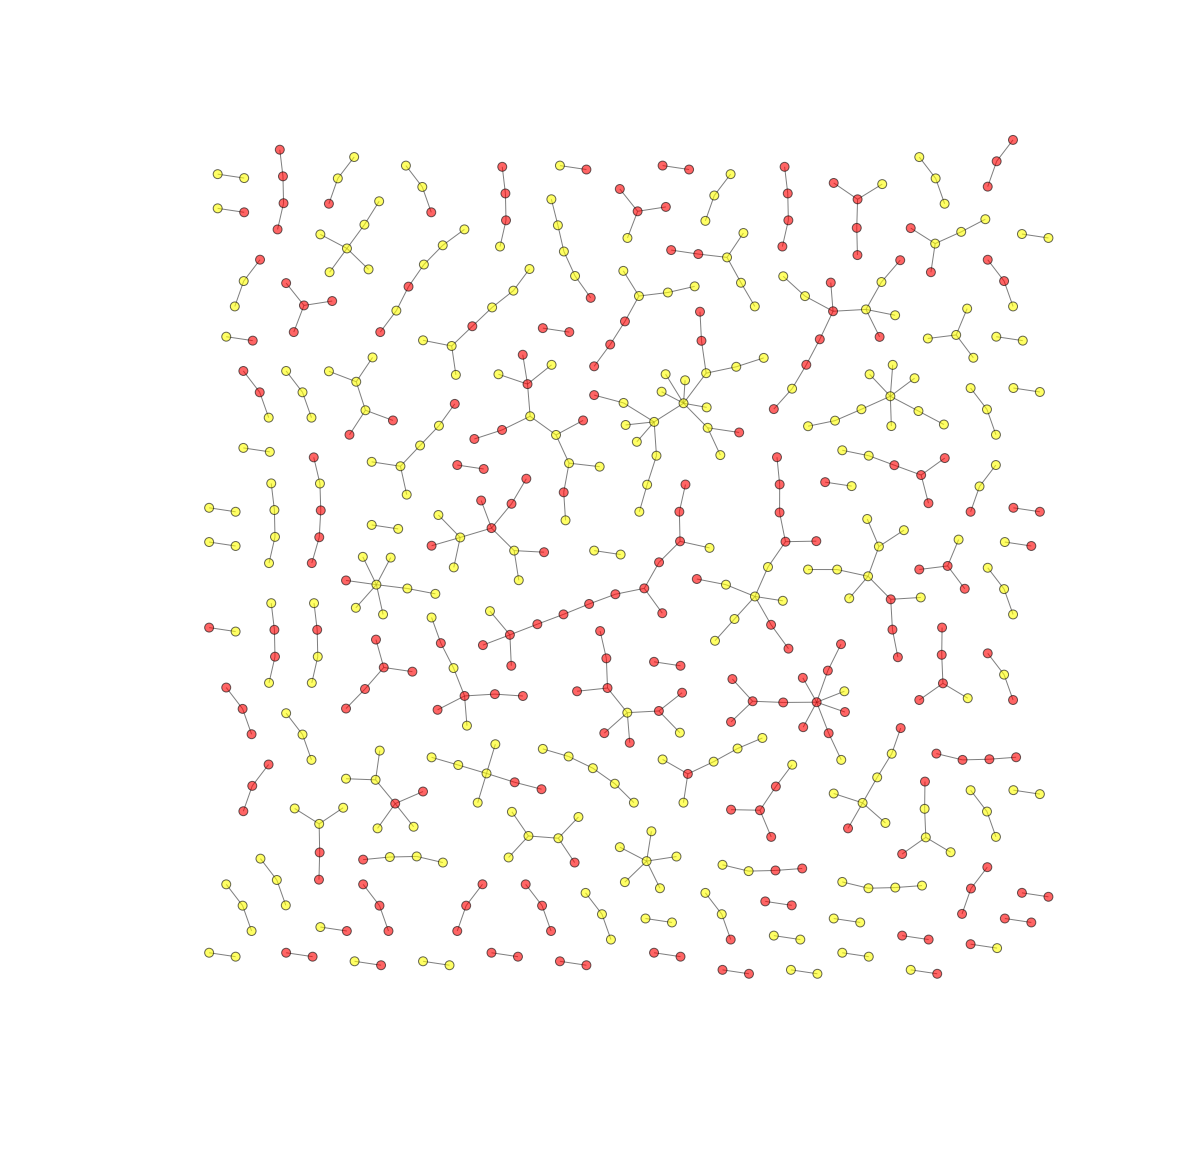

In [6]:
from eden.util import display
display.draw_adjacency_graph(A,y,node_size=80, size=20, layout='graphviz')

In [7]:
from sklearn import metrics

K=metrics.pairwise.pairwise_kernels(X, metric='linear')
print K

[[ 1.          0.36783211  0.1965602  ...,  0.22443494  0.31456581
   0.35573311]
 [ 0.36783211  1.          0.2276576  ...,  0.25694778  0.30783128
   0.32250195]
 [ 0.1965602   0.2276576   1.         ...,  0.30241805  0.24073614
   0.23426697]
 ..., 
 [ 0.22443494  0.25694778  0.30241805 ...,  1.          0.3069365
   0.25918234]
 [ 0.31456581  0.30783128  0.24073614 ...,  0.3069365   1.          0.33147995]
 [ 0.35573311  0.32250195  0.23426697 ...,  0.25918234  0.33147995  1.        ]]


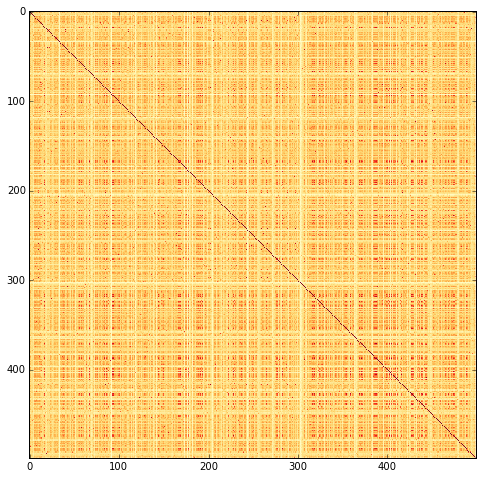

In [8]:
import pylab as plt
plt.figure( figsize=(8,8) )
img = plt.imshow( K, interpolation='none', cmap=plt.get_cmap( 'YlOrRd' ) )
plt.show()